In [64]:
# in this python notebook, we carry out experiments to figure out how to convert the downloaded data into a format which can be used for gradient-based 

data_dir = '/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA' # where all the data is stored 
dir_names = ['NH', 'IN', 'NM', 'CA', 'GA', 'IL', 'MT', 'NE', 'AL', 'WI', 'IA', 'AR', 'AK', 'MD', 'NJ', 'VA', 'MO', 'CO', 'NV', 'SD',
             'WV', 'NC', 'FL', 'TN', 'ID', 'MS', 'MI', 'NY', 'VT', 'OR', 'HI', 'KY', 'OH', 'UT', 'DE', 'MA', 'KS', 'RI', 'WA', 'LA',
             'ND', 'AZ', 'OK', 'MN', 'TX', 'SC', 'PA', 'WY', 'ME', 'DC', 'CT', 'weather']
versionID = 32 # version of the dataset we are using

# we first verify how many files are there for each state

import os
for subdir, dirs, files in os.walk(data_dir):
    if subdir != '.':
        print(subdir, len([f for f in files if os.path.isfile(os.path.join(subdir, f))]))

/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA 7
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/TN 7903
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/IA 2846
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/IN 7357
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/AK 505
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/FL 24812
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/NJ 10746
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/SC 7326
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/CO 6044
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/PA 14531
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/KS 3164
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/MD 5484
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/HI 937
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/MO 6252
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/grouped 2
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/VA 7365
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/TX 27998
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/AR 3283
/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA/weather 3043
/lcrc/pro

In [65]:
# Read the metadata parquet file and verify whether all the (bldg_id,state,in_puma_county_gisjoin)

import pandas as pd
from tqdm import tqdm
df = pd.read_parquet(data_dir+'/upgrade32.parquet')

bldg_id_list = df.index.tolist() # building id List
state_name_list = df['in.state'].tolist() # state name list
county_id_list = df['in.nhgis_county_gisjoin'].tolist() # county gisjoin list

# run loop
ctr0, ctr1 = 0, 0
for a,b,c in (t:=tqdm(zip(bldg_id_list,state_name_list,county_id_list))):
    parquet_path = data_dir + f'/{b}/{a}-{versionID}.parquet'
    weather_path = data_dir + f'/weather/{c}_2018.csv'
    par_exists = os.path.exists(parquet_path)
    wea_exists = os.path.exists(weather_path)
    if not (par_exists and wea_exists):
        print(f'For building_ID: {a}, state: {b}, county: {c}, building data: {par_exists}, weather data: {wea_exists}.')
        # t.set_description(f'Check for building_ID: {a}, state: {b}, county: {c} not nominal.')
    else:
        ctr0 += 1
        # t.set_description(f'Check for building_ID: {a}, state: {b}, county: {c} nominal.')
    
    ctr1 += 1
    
print(f'Verified that {ctr0}/{ctr1} datafiles exist.')


7857it [00:04, 1871.87it/s]

For building_ID: 5486, state: AK, county: G0202750, building data: False, weather data: False.
For building_ID: 5509, state: AK, county: G0202900, building data: True, weather data: False.
For building_ID: 5742, state: AK, county: G0202700, building data: True, weather data: False.


288102it [02:36, 1863.57it/s]

For building_ID: 5611, state: AK, county: G0202900, building data: True, weather data: False.


346185it [03:08, 1840.26it/s]

Verified that 346181/346185 datafiles exist.


In [66]:
# Manually attempt to download some of the missing data

import s3fs
bucket_name = 'oedi-data-lake'
fs = s3fs.S3FileSystem(anon=True)

missing_parquets = [('AK',5486)]
weather_data = ['G0202750','G0202900','G0202700']

parquet_dlist = [f'nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/comstock_amy2018_release_1/timeseries_individual_buildings/by_state/upgrade={versionID}/state={key}/{v}-{versionID}.parquet'
                 for (key,v) in missing_parquets]
weather_dlist = [f'nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/comstock_amy2018_release_1/weather/amy2018/{w}_2018.csv' for w in weather_data]

parquet_locals = [data_dir + f'/{b}' for b,_ in missing_parquets]
weather_locals = [data_dir + f'/weather' for _ in weather_dlist]

for pd,pl in zip(parquet_dlist,parquet_locals):
    s3_path = f's3://{bucket_name}/{pd}'
    if fs.exists(s3_path):
        fs.get(s3_path, pl)
    else:
        print(f'S3 filepath {s3_path} does not exist.')
        
for wd,wl in zip(weather_dlist,weather_locals):
    s3_path = f's3://{bucket_name}/{wd}'
    if fs.exists(s3_path):
        fs.get(s3_path, wl)
    else:
        print(f'S3 filepath {s3_path} does not exist.')

S3 filepath s3://oedi-data-lake/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/comstock_amy2018_release_1/timeseries_individual_buildings/by_state/upgrade=32/state=AK/5486-32.parquet does not exist.
S3 filepath s3://oedi-data-lake/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/comstock_amy2018_release_1/weather/amy2018/G0202750_2018.csv does not exist.
S3 filepath s3://oedi-data-lake/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/comstock_amy2018_release_1/weather/amy2018/G0202900_2018.csv does not exist.
S3 filepath s3://oedi-data-lake/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/comstock_amy2018_release_1/weather/amy2018/G0202700_2018.csv does not exist.


(0.0, 3044.0)

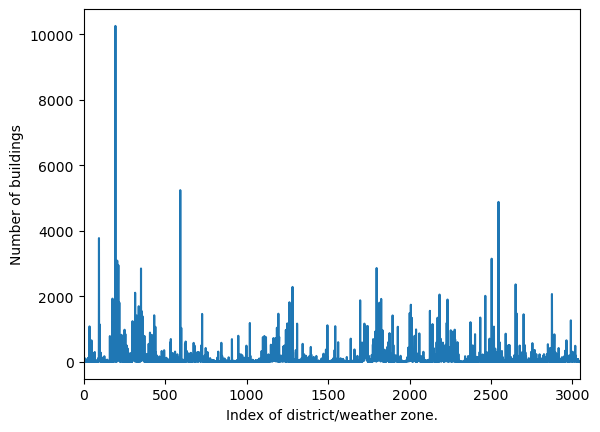

In [67]:
# We now plot the number of buildings per weather area

import numpy as np
import matplotlib.pyplot as plt

# convert to histogram
unique, inverse = np.unique(county_id_list, return_inverse=True)
hist = np.bincount(inverse)

# plot
import matplotlib.pyplot as plt
plt.plot(hist)
plt.ylabel('Number of buildings')
plt.xlabel('Index of district/weather zone.')
plt.xlim((0,hist.size-1))

In [68]:
# Now we experiment over acquiring a specific parquet file, and dig into its innards

import pandas as pd

# We are somewhat replicating from a block above, but the following is a self-contained way to extract data from the data files
df = pd.read_parquet(data_dir + '/upgrade32.parquet')
df1 = df
bldg_id_list = df.index.tolist() # building id List
state_name_list = df['in.state'].tolist() # state name list
county_id_list = df['in.nhgis_county_gisjoin'].tolist() # county gisjoin list

# extract lists of static features
floor_area_list = df['calc.weighted.sqft'].tolist()
wall_area_list = df['out.params.ext_wall_area..m2'].tolist()
window_area_list = df['out.params.ext_window_area..m2'].tolist()

# now test out a building parquet
print(f"Opening data file for building ID {bldg_id_list[0]} and state {state_name_list[0]}")
this_parquet_path = data_dir + f'/{state_name_list[0]}/{bldg_id_list[0]}-{versionID}.parquet'
df = pd.read_parquet(this_parquet_path)

# extract relevant data
consumption = df['out.electricity.total.energy_consumption'].tolist()
time_idx = ((df['timestamp'] - df['timestamp'].dt.normalize()) / np.timedelta64(15, 'm')).astype(int).tolist()
day_idx = df['timestamp'].dt.dayofweek.tolist()

# now test out a weather parquet
print(f"Opening weather file for county ID {county_id_list[0]} and state {state_name_list[0]}")
this_csv_path = data_dir + f'/weather/{county_id_list[0]}_2018.csv'
df = pd.read_csv(this_csv_path)

# extract relevant data
db_temp = np.repeat(df['Dry Bulb Temperature [°C]'].to_numpy(),4).tolist()
w_speed = np.repeat(df['Wind Speed [m/s]'].to_numpy(),4).tolist()

# now save the data as a numpy array and measure the time
data1 = np.array([consumption])
data2 = np.array([[floor_area_list[0],wall_area_list[0],window_area_list[0]]])
wdata = np.array([db_temp,w_speed,time_idx,day_idx])

# npz file - data
import os, time
start = time.time()
np.savez(os.getcwd()+'/test.npz',cons=data1,static=data2)
end = time.time()
fsize = os.path.getsize(os.getcwd()+'/test.npz') / 1024 # kilobytes
print(f"Saving load data in non-compressed format took {end-start}s and is {fsize} kilobytes")
os.remove(os.getcwd()+'/test.npz')

# npz file compressed - data
start = time.time()
np.savez_compressed(os.getcwd()+'/test.npz',cons=data1,static=data2)
end = time.time()
fsize = os.path.getsize(os.getcwd()+'/test.npz') / 1024 # kilobytes
print(f"Saving load data in compressed format took {end-start}s and is {fsize} kilobytes")
os.remove(os.getcwd()+'/test.npz')

# npz file - weather
start = time.time()
np.savez(os.getcwd()+'/test.npz',wdata=wdata)
end = time.time()
fsize = os.path.getsize(os.getcwd()+'/test.npz') / 1024 # kilobytes
print(f"Saving weather data in non-compressed format took {end-start}s and is {fsize} kilobytes")
os.remove(os.getcwd()+'/test.npz')

# npz file compressed - weather
start = time.time()
np.savez_compressed(os.getcwd()+'/test.npz',wdata=wdata)
end = time.time()
fsize = os.path.getsize(os.getcwd()+'/test.npz') / 1024 # kilobytes
print(f"Saving weather data in compressed format took {end-start}s and is {fsize} kilobytes")
os.remove(os.getcwd()+'/test.npz')

Opening data file for building ID 74 and state AL
Opening weather file for county ID G0101010 and state AL
Saving load data in non-compressed format took 0.0048182010650634766s and is 274.267578125 kilobytes
Saving load data in compressed format took 0.013019561767578125s and is 257.1572265625 kilobytes
Saving weather data in non-compressed format took 0.0015170574188232422s and is 1095.2578125 kilobytes
Saving weather data in compressed format took 0.0123291015625s and is 45.07421875 kilobytes


In [69]:
# # example of splits (DO NOT EXECUTE) - now present in 4.py

# import os
# import numpy as np
# import pandas as pd
# from collections import defaultdict
# from itertools import islice
# from tqdm import tqdm

# def split_dict(input_dict, n):
#     # split a dictionary into n almost-equal parts
#     it = iter(input_dict)
#     return [dict(islice(it, i)) for i in [len(input_dict) // n + (1 if x < len(input_dict) % n else 0)  for x in range(n)]]

# base_dir = '/lcrc/project/NEXTGENOPT/NREL_COMSTOCK_DATA' # data directory
# versionID = 32 # NREL Comstock upgrade version

# # read default PARQUET file
# metadata = pd.read_parquet(base_dir+f'/upgrade{versionID}.parquet')

# # extract relevant info as lists
# bldg_id_list = metadata.index.tolist() # building id List
# state_name_list = metadata['in.state'].tolist() # state name list
# county_id_list = metadata['in.nhgis_county_gisjoin'].tolist() # county gisjoin list
# floor_area_list = metadata['calc.weighted.sqft'].tolist() # floor area list
# wall_area_list = metadata['out.params.ext_wall_area..m2'].tolist() # wall area list
# window_area_list = metadata['out.params.ext_window_area..m2'].tolist() # window area list

# # group by county id
# grouped = defaultdict(list)
# for a,b,c,d,e,f in zip(bldg_id_list,state_name_list,county_id_list,floor_area_list,wall_area_list,window_area_list):
#     grouped[c].append((a,b,c,d,e,f))
    
# # make directory to store datas
# os.makedirs(base_dir+'/grouped',exist_ok=True)
    
# # loop across dict keys
# for key in tqdm(grouped.keys()):
#     # read weather data
#     weather_path = base_dir + f'/weather/{c}_2018.csv'
#     if not os.path.exists(weather_path):
#         continue
#     else:
#         weather_df = pd.read_csv(weather_path)
#         db_temp = np.repeat(weather_df['Dry Bulb Temperature [°C]'].to_numpy(),4).tolist()
#         w_speed = np.repeat(weather_df['Wind Speed [m/s]'].to_numpy(),4).tolist()
#         dtidx_recorded = False # we will record daytime indices when we load the consumption files
#         data1, data2 = [], []
#         for a,b,c,d,e,f in grouped[key]:
#             bldg_path = base_dir + f'/{b}/{a}-{versionID}.parquet'
#             if os.path.exists(bldg_path):
#                 bldg_df = pd.read_parquet(bldg_path)
#             else:
#                 continue
#             consumption = bldg_df['out.electricit y.total.energy_consumption'].tolist()
#             if not dtidx_recorded:
#                 time_idx = ((bldg_df['timestamp'] - bldg_df['timestamp'].dt.normalize()) / np.timedelta64(15, 'm')).astype(int).tolist()
#                 day_idx = bldg_df['timestamp'].dt.dayofweek.tolist()
#                 dtidx_recorded = True
#             data1.append(consumption)
#             data2.append([d,e,f])
#         if dtidx_recorded == False:
#             continue
#         wdata = [db_temp,w_speed,time_idx,day_idx]
#         data1, data2, wdata = np.array(data1), np.array(data2), np.array(wdata)
#         # save files
#         np.savez_compressed(base_dir+f'/grouped/{key}_data.npz',load=data1,static=data2)
#         np.savez_compressed(base_dir+f'/grouped/{key}_data.npz',wdata=wdata)
        